In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gpflow.utilities import print_summary, set_trainable, to_default_float
import gpflow
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import os
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import datetime

import sys
sys.path.append('../../src')
from data_preparation import get_birth_data, separate_data, train_test_normalise
from useful_fun import plot_sliding_window, number_outof_CI

# import warnings
# warnings.filterwarnings("ignore")

In [2]:
# load data

# whole dataset
data = get_birth_data()
x, y = separate_data(data) # y is unnormalised: good!

# get date for x-axis in plots: mm-yyyy
def get_xticks(df):
    dff = df.groupby(by='m-y').first()
    pos = dff.ids; pos = pos[1:]
    labels = dff.index; labels = labels[1:]
    return pos, labels

2022-08-12 18:38:43.306276: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-12 18:38:44.130181: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9646 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [3]:
# def train_test_normalise(train_df, test_df):
#     y_train = train_df.births
#     mean_train = np.mean(y_train)
#     std_train = np.std(y_train)
#     y_train = (y_train - mean_train) / std_train
#     y_test = test_df.births
#     y_test = (y_test - mean_train) / std_train
#     return y_train, y_test

# Sliding Window
### Simple one-latent function model with SVGP

        y = f(x) + e
        f = GP(0, RBF)

        l = InvGama()
        sigma = Gamma()

In [4]:
def split_dataframe_by_position(df, splits):
    """
    Takes a dataframe and an integer of the number of splits to create.
    Returns a list of dataframes.
    """
    dataframes = []
    index_to_split = len(df) // splits
    start = 0
    end = index_to_split
    for split in range(splits):
        temporary_df = df.iloc[start:end, :]
        dataframes.append(temporary_df)
        start += index_to_split
        end += index_to_split
    return dataframes

In [5]:
def optimise_model(model, x_train, y_train):
    train_data = (x_train, y_train)
    loss_fn = model.training_loss_closure(train_data) 

    gpflow.utilities.set_trainable(model.q_mu, False)
    gpflow.utilities.set_trainable(model.q_sqrt, False)

    variational_vars = [(model.q_mu, model.q_sqrt)]
    natgrad_opt = gpflow.optimizers.NaturalGradient(gamma=0.1)
    adam_vars = model.trainable_variables
    adam_opt = tf.optimizers.Adam(0.01)

    @tf.function
    def optimisation_step():
        natgrad_opt.minimize(loss_fn, variational_vars)
        adam_opt.minimize(loss_fn, adam_vars)

    epochs = 50
    for epoch in range(1, epochs + 1):
        optimisation_step()

4
iteration:  0


2022-08-12 18:39:20.262987: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-08-12 18:39:27.479115: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x1ebf5ab0


iteration:  1
iteration:  2
iteration:  3
iteration:  4


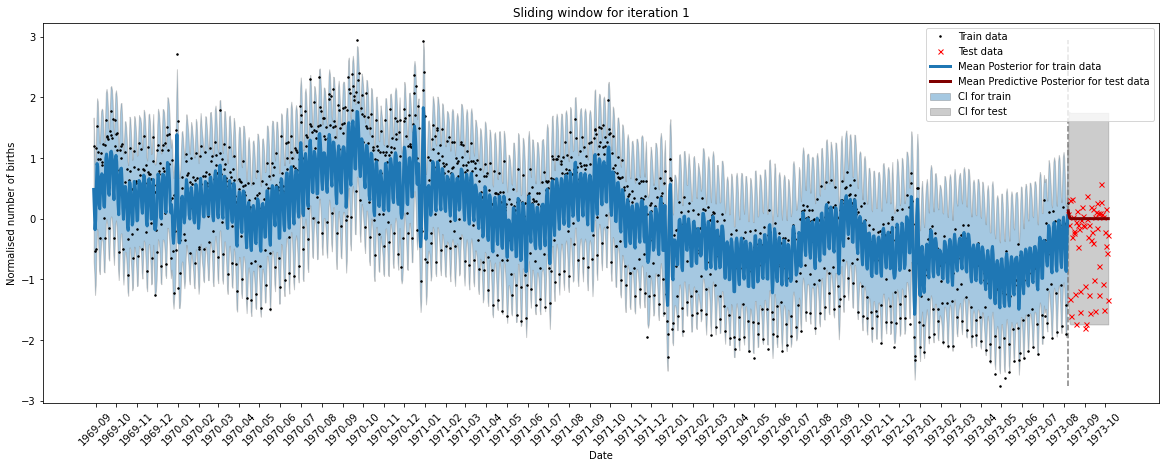

iteration:  5
iteration:  6
iteration:  7
iteration:  8
iteration:  9
iteration:  10
iteration:  11
iteration:  12
iteration:  13
iteration:  14
iteration:  15
iteration:  16
iteration:  17
iteration:  18
iteration:  19
iteration:  20
iteration:  21
iteration:  22
iteration:  23
iteration:  24
iteration:  25
iteration:  26
iteration:  27
iteration:  28
iteration:  29
iteration:  30
iteration:  31
iteration:  32
iteration:  33
iteration:  34
iteration:  35
iteration:  36
iteration:  37
iteration:  38
iteration:  39
iteration:  40
iteration:  41
iteration:  42
iteration:  43
iteration:  44
iteration:  45
iteration:  46
iteration:  47
iteration:  48
iteration:  49
iteration:  50


KeyboardInterrupt: 

In [7]:
splits = 121 # two month split
split_dataframes = split_dataframe_by_position(data, splits)

# evaluation lists
ELBO_train = []
mse_train = []; mae_train = []; n_outof_CI_train = []
mse_test = [];  mae_test = [];  n_outof_CI_test = []

# window sizes
window_size = 24 # 5 for 10months
iterations = splits-window_size

# which iteration to plot
iteration_plot = np.random.randint(low=0, high=iterations)
print(iteration_plot)

# number of inducing points
M = None

for i in range(splits-window_size):
    print('iterations to go through: ', iterations)
    df = pd.DataFrame()

    # select data
    for df_ind in range(window_size):
        if df_ind == 0:
            df = split_dataframes[i]
        else :
            df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

    whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
    pos, labels = get_xticks(whole_data)

    # normalise & separate data
    df_train = df; df_test = split_dataframes[i+window_size]
    df_train, df_test = train_test_normalise(df_train, df_test)
    x_train, y_train = separate_data(df_train)
    x_test, y_test = separate_data(df_test)
    
    # build model
    kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
    Z = x_train.numpy().copy()
    # Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

    # optimise
    optimise_model(model, x_train, y_train)

    # predict
    mean_train, var_train = model.predict_f(x_train)
    mean_test, var_test = model.predict_f(x_test)

    # evaluate
    ELBO_train.append(model.elbo((x_train,y_train)).numpy())
    mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
    mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))

    if i == iteration_plot:
        plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=1)
    

In [ ]:
splits = 60 # 4 month split
split_dataframes = split_dataframe_by_position(data, splits)

# evaluation lists
ELBO_train = []
mse_train = []; mae_train = []; n_outof_CI_train = []
mse_test = [];  mae_test = [];  n_outof_CI_test = []

# window sizes
window_size =  # 5 for 10months
iterations = splits-window_size

# which iteration to plot
iteration_plot = np.random.randint(low=0, high=iterations)
print(iteration_plot)

# number of inducing points
M = None

for i in range(splits-window_size):
    print('iterations to go through: ', iterations)
    df = pd.DataFrame()

    # select data
    for df_ind in range(window_size):
        if df_ind == 0:
            df = split_dataframes[i]
        else :
            df = pd.concat([df, split_dataframes[i+df_ind]], axis=0)

    whole_data = pd.concat([df, split_dataframes[i+window_size]], axis=0)
    pos, labels = get_xticks(whole_data)

    # normalise & separate data
    df_train = df; df_test = split_dataframes[i+window_size]
    df_train, df_test = train_test_normalise(df_train, df_test)
    x_train, y_train = separate_data(df_train)
    x_test, y_test = separate_data(df_test)
    
    # build model
    kernel = gpflow.kernels.RBF(lengthscales = 1, variance = 1)
    Z = x_train.numpy().copy()
    # Z = np.linspace(x_train.numpy().min(), x_train.numpy().max(), M)[:, None]
    model = gpflow.models.SVGP(kernel, gpflow.likelihoods.Gaussian(), Z, mean_function=gpflow.mean_functions.Zero(), num_data=M)
    set_trainable(model.likelihood.variance, False)
    model.kernel.lengthscales.prior = tfp.distributions.InverseGamma(to_default_float(0.5), to_default_float(1))
    model.kernel.variance.prior = tfp.distributions.Gamma(to_default_float(2), to_default_float(3))

    # optimise
    optimise_model(model, x_train, y_train)

    # predict
    mean_train, var_train = model.predict_f(x_train)
    mean_test, var_test = model.predict_f(x_test)

    # evaluate
    ELBO_train.append(model.elbo((x_train,y_train)).numpy())
    mse_train.append(mean_squared_error(y_train, mean_train)); mae_train.append(mean_absolute_error(y_train, mean_train)); n_outof_CI_train.append(number_outof_CI(y_train, mean_train, var_train))
    mse_test.append(mean_squared_error(y_test, mean_test)); mae_test.append(mean_absolute_error(y_test, mean_test)); n_outof_CI_test.append(number_outof_CI(y_test, mean_test, var_test))

    if i == iteration_plot:
        plot_sliding_window(x_train, x_test, y_train, y_test, mean_train, mean_test, var_train, var_test, pos, labels, iteration=1)
    